Overall class counts: {1: 3047, 0: 1953}


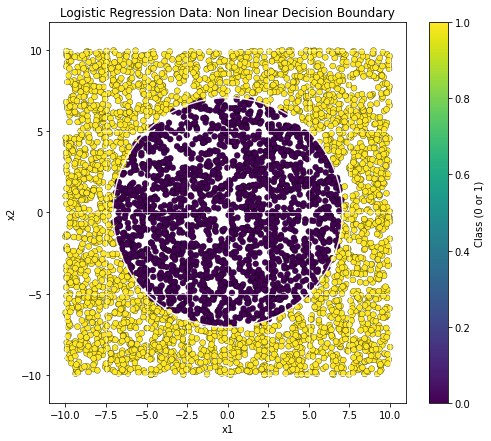

Train counts: {1: 2438, 0: 1562}
Test counts : {1: 609, 0: 391}

=== Logistic Regression ===
Accuracy: 1.0
ROC AUC : 1.0
Confusion matrix:
 [[391   0]
 [  0 609]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       391
           1      1.000     1.000     1.000       609

    accuracy                          1.000      1000
   macro avg      1.000     1.000     1.000      1000
weighted avg      1.000     1.000     1.000      1000


=== KNN (k=15, distance weights) ===
Accuracy: 0.995
ROC AUC : 0.9999
Confusion matrix:
 [[387   4]
 [  1 608]]
              precision    recall  f1-score   support

           0      0.997     0.990     0.994       391
           1      0.993     0.998     0.996       609

    accuracy                          0.995      1000
   macro avg      0.995     0.994     0.995      1000
weighted avg      0.995     0.995     0.995      1000



In [1]:
# Quadratic decision boundary + LogReg & KNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# ---------- 1) Generate data ----------
N = 5_000
np.random.seed(10)
x1 = np.random.uniform(-10, 10, size=N)
np.random.seed(100)
x2 = np.random.uniform(-10, 10, size=N)

data = pd.DataFrame({'x1': x1, 'x2': x2})
data['x1_squared'] = data['x1']**2
data['x2_squared'] = data['x2']**2

# Quadratic boundary: label = 1{ x1^2 + x2^2 >= R2 }
R2 = 50.0  # radius^2 (sqrt(50) ≈ 7.07)
data['label'] = ((data['x1_squared'] + data['x2_squared']) >= R2).astype(int)

print("Overall class counts:", data['label'].value_counts().to_dict())

# ---------- 2) Plot the dataset (your expected figure) ----------
plt.figure(figsize=(8, 7))
sc = plt.scatter(data['x1'], data['x2'], c=data['label'],
                 cmap='viridis', s=35, edgecolor='k', linewidths=0.3)
plt.colorbar(sc, label='Class (0 or 1)')
plt.grid(True, color='white', linewidth=1.0, alpha=0.6)
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('Logistic Regression Data: Non linear Decision Boundary')
plt.axis('equal')
# (Optional) draw the circle at sqrt(R2) so you can see the boundary
circle = plt.Circle((0, 0), np.sqrt(R2), fill=False, color='white', linewidth=1.5, alpha=0.9)
plt.gca().add_artist(circle)
plt.show()

# ---------- 3) Stratified 80/20 split ----------
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=123)
for tr_idx, te_idx in sss.split(data, data['label']):
    training_data = data.iloc[tr_idx].copy()
    test_data     = data.iloc[te_idx].copy()

print("Train counts:", training_data['label'].value_counts().to_dict())
print("Test counts :", test_data['label'].value_counts().to_dict())

# ---------- 4) Train Logistic Regression & KNN on quadratic features ----------
feature_cols = ['x1', 'x2', 'x1_squared', 'x2_squared']

X_train = training_data[feature_cols].values
y_train = training_data['label'].astype(int).values
X_test  = test_data[feature_cols].values
y_test  = test_data['label'].astype(int).values

logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=15, weights='distance'))
])

logreg.fit(X_train, y_train)
knn.fit(X_train, y_train)

# ---------- 5) Evaluate ----------
# Logistic Regression
lr_pred  = logreg.predict(X_test)
lr_proba = logreg.predict_proba(X_test)[:, 1]
print("\n=== Logistic Regression ===")
print("Accuracy:", round(accuracy_score(y_test, lr_pred), 4))
print("ROC AUC :", round(roc_auc_score(y_test, lr_proba), 4))
print("Confusion matrix:\n", confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred, digits=3))

# KNN
knn_pred  = knn.predict(X_test)
knn_proba = knn.predict_proba(X_test)[:, 1]
print("\n=== KNN (k=15, distance weights) ===")
print("Accuracy:", round(accuracy_score(y_test, knn_pred), 4))
print("ROC AUC :", round(roc_auc_score(y_test, knn_proba), 4))
print("Confusion matrix:\n", confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred, digits=3))
